# install simple salesforce

In [ ]:
#pip install simple_salesforce
# pip install tabpy

In [1]:
#Prerequisites

import sys
!{sys.executable} -m pip install --user networkx
!{sys.executable} -m pip install --user numpy
!{sys.executable} -m pip install --user pandas

import networkx as nx
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import requests
import csv
import glob
import scipy.sparse
import pickle

from simple_salesforce import Salesforce
from io import StringIO
from pandas import DataFrame

In [ ]:
#sf = Salesforce(username='',password='', security_token='')

sf_instance = 'https://ua-trellis.lightning.force.com/' #Your Salesforce Instance URL
reportId = '00O6R000008QxpyUAC' # add report id
export = '?isdtp=p1&export=1&enc=UTF-8&xf=csv'
sfUrl = sf_instance + reportId + export
response = requests.get(sfUrl, headers=sf.headers, cookies={'sid': sf.session_id})
download_report = response.content.decode('utf-8')
df1 = pd.read_csv(StringIO(download_report))

In [ ]:
os.getcwd()

directory = '/Users/jungmeepark/Documents/Trellis/Network_Analysis_Tableau/data/salesforce/'

for file_name in glob.glob(directory+'*.csv'):
    x = np.genfromtxt(file_name,delimiter=',')[:,2]
    # do your calculations


# Define the directory path
as /Users/jungmeepark/Documents/Trellis/Network_Analysis_Tableau/data/salesforce
directory = '/Users/jungmeepark/Documents/Trellis/Network_Analysis_Tableau/data/salesforce/'

# Get a list of all files in the directory
files = os.listdir(directory)

# Filter out only the CSV files
csv_files = [file for file in files if file.endswith('.csv')]

# Loop through each CSV file and read it
for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path)
    # Now you can work with the DataFrame 'df' for each CSV file
    print("Loaded:", file)



In [2]:
# Read in Source File - NB this must match the schema requirements
# read in data
# /Users/jungmeepark/Documents/Trellis/Network_Analysis_Tableau/data/salesforce
cases_report_SF = pd.read_csv('~/Documents/Trellis/Network_Analysis_Tableau/data/salesforce/POC_Cases_May22_2024.csv')
CodeType = 'latin1' # https://docs.python.org/3/library/codecs.html#standard-encodings

/var/folders/wr/p82k0vm11j17r80bp7wf3swc0000gs/T/ipykernel_18808/2963542495.py:4: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  cases_report_SF = pd.read_csv('~/Documents/Trellis/Network_Analysis_Tableau/data/salesforce/POC_Cases_May22_2024.csv')


In [3]:
value_counts = cases_report_SF['Case Record Type'].value_counts()
print("Value Counts:\n", value_counts)

# Count the number of unique values
unique_count = cases_report_SF['Case Record Type'].nunique()
print("Number of unique Case Record Types:", unique_count)


Value Counts:
 Service    198679
Note       139320
Name: Case Record Type, dtype: int64
Number of unique Case Record Types: 2


In [3]:
datatypes = cases_report_SF.dtypes 
datatypes

Subject                  object
Date/Time Opened         object
Open                      int64
Closed                    int64
Department               object
Contact: Email           object
Emplid                   object
Case Last Modified By    object
Contact ID               object
Age (Hours)               int64
Case Record Type         object
dtype: object

In [ ]:
#cases_report_SF = cases_report_SF[['Department', 'Case Last Modified By','Contact: Email', 'Emplid', 'Case Record Type']]

In [4]:
# Filter out rows where case record type and Case last modified by is NA or empty
#cases_report_SF = cases_report_SF.dropna(subset=['Case Record Type', 'Department'])
cases_report_SF = cases_report_SF.dropna(subset=['Case Record Type', 'Emplid', 'Department', 
                                                 'Case Last Modified By'])
cases_report_SF.shape

(166061, 11)

In [5]:
# Convert 'Appointment Date' column to datetime
cases_report_SF['Date/Time Opened'] = pd.to_datetime(cases_report_SF['Date/Time Opened'])

# Convert the "Open/Close Date" column to datetime objects
cases_report_SF['Date/Time Opened'] = pd.to_datetime(cases_report_SF['Date/Time Opened'], format="%m/%d/%Y %I:%M:%S %p")

# Extract the date part
cases_report_SF['Date Opened'] = cases_report_SF['Date/Time Opened'].dt.date

cases_report_SF['Date Opened']= pd.to_datetime(cases_report_SF['Date Opened'])

In [6]:
# Calculate today's date
today = pd.to_datetime('today').normalize()
cases_report_SF['today'] = today


In [7]:
# Calculate days since 'openDate'
cases_report_SF['days_since'] = (cases_report_SF['today'] - cases_report_SF['Date Opened']).dt.days

In [8]:
# filter dates to 2024
#filtered_df[(filtered_df['date']>datetime.date(2024,1,1)) & (filtered_df['date']<datetime.date(2024,5,5))]
cases_report_SF = cases_report_SF[(cases_report_SF['Date Opened'] > "2024-01-01") & (cases_report_SF['Date Opened'] < "2024-07-01")]


In [9]:
# add an index column

cases_report_SF['index'] = range(1, len(cases_report_SF) + 1)
#filtered_df['index'] = filtered_df.index

# Display the updated DataFrame
#print(filtered_df.head())

In [10]:
cases_report_SF = cases_report_SF.rename(columns={'Contact: Email': 'Student Email', 'Case Last Modified By': 'Advisor Name'})

In [11]:
# create a source column
cases_report_SF['Source'] = cases_report_SF.groupby(['Emplid']).ngroup()

In [12]:
cases_report_SF['Target'] = cases_report_SF.groupby(['Department']).ngroup()

In [13]:
cases_report_SF['Source'] = cases_report_SF['Source'].map(str)
cases_report_SF['Target'] = cases_report_SF['Target'].map(str)

In [14]:
# Add directions to d3
cases_report_SF['Direction'] = cases_report_SF['Source'] + ' -> ' + cases_report_SF['Target']

In [15]:
# Group by 'NAME' and check if any row within the group has a non-null 'DEPARTMENT'
grouped = cases_report_SF.groupby('Advisor Name')['Department'].transform('first')
# Impute the 'DEPARTMENT' value within each group
cases_report_SF['Department'] = cases_report_SF['Department'].fillna(grouped)

In [35]:
# Count the number of contacts between each source (student) and target (department)
cases_report_SF['ContactCount'] = cases_report_SF.groupby(['Source', 'Target'])['Source'].transform('count')


In [36]:
# FOLLOWING KNIPPENBERG

# Save the DataFrame to a CSV file
cases_report_SF.to_csv('~/Documents/Trellis/Network_Analysis_Tableau/data/generated_from_knipp/py-cases_report_SF_May22_2024.csv', index=False)  # Set index=False to exclude the index from the CSV file


In [38]:
arr_SrcTgt = np.array(cases_report_SF[['Source','Target']])

In [39]:
# Count the number of contacts between each student and department
contact_counts = cases_report_SF.groupby(['Source', 'Target']).size().reset_index(name='ContactCount')
print(contact_counts)


      Source Target  ContactCount
0          0      7             2
1          1     29             1
2         10     29             3
3        100     17             1
4       1000     29             1
...      ...    ...           ...
36255   9995     10             1
36256   9996      7             6
36257   9997      7            12
36258   9998     29             4
36259   9999     29             3

[36260 rows x 3 columns]


In [40]:
# Create a MultiDiGraph
G = nx.MultiDiGraph()

# Add edges with the 'ContactCount' as weight
for _, row in contact_counts.iterrows():
    student = row['Source']
    department = row['Target']
    contact_count = row['ContactCount']
    G.add_edge(student, department, weight=contact_count)

# try to add this contact_count into the df

In [41]:
# Print the edges with weights
for u, v, data in G.edges(data=True):
    print(f"Student: {u}, Department: {v}, Contact Count: {data['weight']}")

Student: 0, Department: 7, Contact Count: 2
Student: 7, Department: 29, Contact Count: 1
Student: 1, Department: 29, Contact Count: 1
Student: 29, Department: 29, Contact Count: 1
Student: 10, Department: 29, Contact Count: 3
Student: 100, Department: 17, Contact Count: 1
Student: 17, Department: 29, Contact Count: 1
Student: 1000, Department: 29, Contact Count: 1
Student: 10000, Department: 29, Contact Count: 1
Student: 10001, Department: 29, Contact Count: 1
Student: 10002, Department: 29, Contact Count: 1
Student: 10003, Department: 7, Contact Count: 6
Student: 10004, Department: 7, Contact Count: 4
Student: 10005, Department: 17, Contact Count: 1
Student: 10006, Department: 29, Contact Count: 1
Student: 10007, Department: 25, Contact Count: 1
Student: 25, Department: 29, Contact Count: 1
Student: 10008, Department: 29, Contact Count: 2
Student: 10009, Department: 29, Contact Count: 3
Student: 1001, Department: 7, Contact Count: 4
Student: 10010, Department: 29, Contact Count: 3
Stu

In [42]:
# Create Network Graph Coordinates...
# G = nx.MultiDiGraph()
G.add_edges_from(arr_SrcTgt)
# dict_Coords = nx.spring_layout(G) 


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 2,


In [43]:
# Draw the graph
dict_Coords = nx.spring_layout(G, iterations=10)
#plt.figure(figsize=(10, 8))
#nx.draw(G, dict_Coords, with_labels=True, node_color='lightblue', node_size=3000, font_size=15, font_weight='bold', arrowsize=20)



# Draw edge labels with the contact count
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, dict_Coords, edge_labels=edge_labels)

plt.title('Student-Department Contact Graph')
plt.show()


In [44]:
# Create Graph Coordinates File...
df_Raw_Coords = DataFrame(dict_Coords)
df_Raw_Coords = df_Raw_Coords.T
df_Raw_Coords.columns = ['X','Y']
df_Raw_Coords.to_csv('~/Documents/Trellis/Network_Analysis_Tableau/data/generated_from_knipp/CoordsFile_merged_May22_2024.csv', 
                     index_label='NodeName')
#print(df_Raw_Coords)

In [45]:
# Create Bridge File... 
# Tableau Code: IF [Src-Tgt]/2 = ROUND([Src-Tgt]/2) THEN 'Source' ELSE 'Target' END
arr_SrcTgt2 = arr_SrcTgt.reshape(1,(len(arr_SrcTgt)*2)) 
arr_SrcTgt2 = arr_SrcTgt2.reshape(-1) 
df_SrcTgt = DataFrame(arr_SrcTgt2,columns=['NodeName']) 
arr_Index = []
for i in range(1,(len(arr_SrcTgt)+1)):
    arr_Index.append(i)
    arr_Index.append(i)
df_SrcTgt['c_Index'] = arr_Index 

df_SrcTgt.to_csv('~/Documents/Trellis/Network_Analysis_Tableau/data/generated_from_knipp/BridgeFile_merged_May22_2024.csv',
                 index_label='Src-Tgt')
#print(df_ScrTgt.head())

In [46]:
# Create Graph Coordinates File...
df_Raw_Coords = DataFrame(dict_Coords)
df_Raw_Coords = df_Raw_Coords.T
df_Raw_Coords.columns = ['X','Y']
df_Raw_Coords.to_csv('~/Documents/Trellis/Network_Analysis_Tableau/data/generated_from_knipp/CoordsFile_merged_May22_2024.csv', 
                     index_label='NodeName')
#print(df_Raw_Coords)

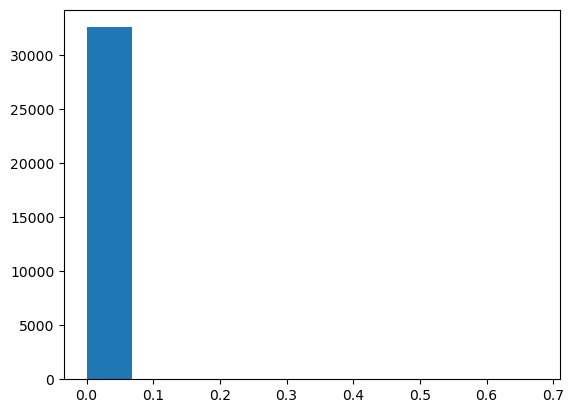

In [47]:
# betweenness centrality
plt.hist(nx.centrality.closeness_centrality(G).values());

In [ ]:
# nx.diameter(Q)

In [ ]:
# nx.cluster.average_clustering(Q)

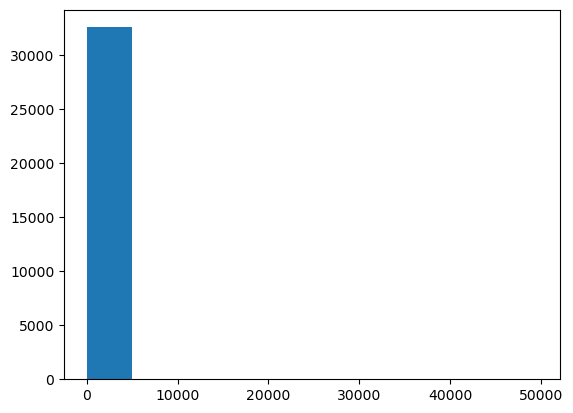

In [49]:
# degree distribution (a histogram of how many edges each node has)

plt.hist([v for k,v in nx.degree(G)]);

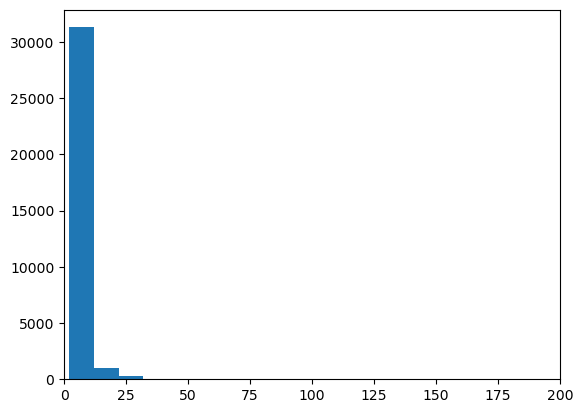

In [48]:

degrees = [v for k, v in nx.degree(G)]

# Calculate the range of your data
min_degree = min(degrees)
max_degree = max(degrees)

# Calculate the number of bins based on increments of 10
num_bins = int((max_degree - min_degree) / 10) + 1

# Plot the histogram
plt.hist(degrees, bins=num_bins)
plt.xlim(0, 200)
plt.show()

In [ ]:
print('Run Completed Successfully')

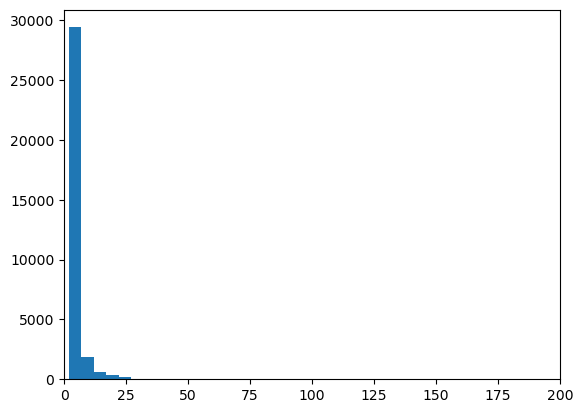

In [50]:
degrees = [v for k, v in nx.degree(G)]

# Calculate the range of your data
min_degree = min(degrees)
max_degree = max(degrees)  # Truncate the maximum degree to 600

# Calculate the number of bins based on increments of 5
num_bins = int((max_degree - min_degree) / 5) + 1

# Plot the histogram
plt.hist(degrees, bins=num_bins)
plt.xlim(0, 200)  # Set the limit of x-axis from 0 to 600
plt.show()